In [1]:
# © 2024 Bill Chow. All rights reserved.
# Unauthorized use, modification, or distribution of this code is strictly prohibited.

import datetime
import enum
import os
import time

import IPython.display
import jax
import jax.numpy as jnp
import jax.random
import mctx
import orbax.checkpoint as ocp
import pgx

import main
from common import *
from network import model

2024-07-14 19:28:16.045001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 19:28:16.064949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 19:28:16.065006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 19:28:16.783393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-14 19:28:17,359 [INFO    ] __main__: jax.local_devices(): [CpuDevice(id=0)]
2024-07-14 19:28:17,360 [INFO    ] __main__: selecting devices: [CpuDevice(id=0)]
2024-07-14 19:28:17,360 [INFO    ] __main__: JAX found 1 devices


In [2]:
def next_action(train_state: TrainState, state: pgx.State, rng_key: jax.Array) -> jax.Array:
    params, batch_stats = train_state.params, train_state.batch_stats
    logits, value = model.apply({'params': params, 'batch_stats': batch_stats}, state.observation, train=False)
    root = mctx.RootFnOutput(prior_logits=logits, value=value, embedding=state)

    policy_output = mctx.gumbel_muzero_policy(
        params=train_state,
        rng_key=rng_key,
        root=root,
        recurrent_fn=main.recurrent_function,
        num_simulations=800,
        invalid_actions=~state.legal_action_mask,  # Take note of the negation symbol
        gumbel_scale=0.)  # Just play its best against us

    with jnp.printoptions(precision=3):
        logger.info(f'policy: {policy_output.action_weights}\nvalue: {value}')  

    return policy_output.action

In [3]:
# Restore state checkpoint if available
train_state = main.create_train_state(model, jax.random.key(0), config.optimizer)
latest_step = checkpoint_manager.latest_step()

if latest_step is not None:
    train_state = checkpoint_manager.restore(latest_step, args=ocp.args.StandardRestore(train_state))
    print(f'loaded model from checkpoint {latest_step}')
else:
    print(f'no checkpoint found in \'{os.path.realpath(f"checkpoints/{config.run_name}")}\'')
    exit(-1)

loaded model from checkpoint 25003


In [4]:
env = pgx.make(config.env_id)

init_fn = jax.vmap(env.init)
step_fn = jax.vmap(env.step)

batch_size = 1
rng_key = jax.random.key(int(datetime.datetime.now().timestamp()))
rng_key, subkey = jax.random.split(rng_key)
keys = jax.random.split(subkey, batch_size)
del subkey


class Turn(enum.Flag):
    HUMAN = bool(0)
    COMPUTER = bool(1)


states = []
state = init_fn(keys)
del keys
turn = Turn(0)


# Decide who is the first player
def decide_turn():
    global rng_key, turn
    rng_key, subkey = jax.random.split(rng_key)
    turn = Turn(bool(jax.random.randint(key=subkey, shape=(), minval=0, maxval=2)))
    del subkey


def new_game():
    global rng_key, states, state
    rng_key, subkey = jax.random.split(rng_key)
    keys = jax.random.split(subkey, batch_size)
    del subkey
    states = []
    state = init_fn(keys)
    # PGX library randomizes the starting player without documenting it
    # No wonder they require a key for env.init
    # Without this, state.rewards can give 1 or -1 even if the same player wins
    state = state.replace(current_player=jnp.zeros_like(state.current_player))
    del keys
    decide_turn()
    print('{} will go first'.format('computer' if turn == Turn.COMPUTER else 'you'))


new_game()

computer will go first


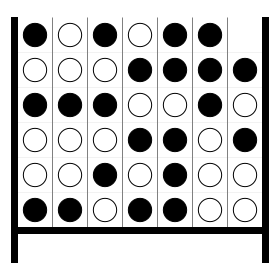

you lose


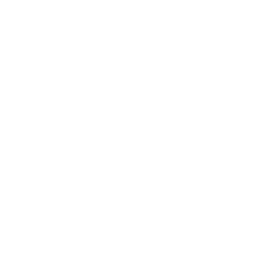

In [5]:
def display_state():
    pgx.save_svg(state=state, filename=f'{config.env_id}.svg')
    IPython.display.clear_output()
    IPython.display.display_svg(IPython.display.SVG(f'{config.env_id}.svg'))


def computer_apply_action():
    global rng_key, state
    rng_key, subkey = jax.random.split(rng_key)
    action = next_action(train_state, state, subkey)
    del subkey
    state = step_fn(state, action)
    states.append(state)
    display_state()


def ask_for_user_action():
    global state
    column = -1

    while not (1 <= column <= 7):
        try:
            column = int(input('Column [1-7]: '))
        except:
            column = -1
            pass

    state = step_fn(state, jnp.asarray(column - 1).reshape((1,)))  # Convert to 0-indexed action
    states.append(state)
    display_state()


# Let computer play first if it is the first player
if turn == Turn.COMPUTER:
    computer_apply_action()
else:
    display_state()

while not (state.terminated or state.truncated):
    ask_for_user_action()
    if state.terminated or state.truncated:
        break
    computer_apply_action()

assert states[-1].terminated  # No reason game should be truncated
rewards = states[-1].rewards[0][int(bool(turn))].item()
print('you %s' % ('win' if rewards == 1 else 'draw' if rewards == 0 else 'lose'))

pgx.save_svg_animation(states, f'{config.env_id}.svg', frame_duration_seconds=1.)
IPython.display.display_svg(IPython.display.SVG(f'{config.env_id}.svg'))

Call `new_game()` to restart the game

In [ ]:
new_game()

In [ ]:
def display_simulation():
    while not (state.terminated or state.truncated):
        computer_apply_action()

    pgx.save_svg_animation(states, f'{config.env_id}.svg', frame_duration_seconds=1.)
    IPython.display.display_svg(IPython.display.SVG(f'{config.env_id}.svg'))

display_simulation()

In [ ]:
def debug_nn(train_state: TrainState, state: pgx.State, rng_key: jax.Array) -> jax.Array:
    params, batch_stats = train_state.params, train_state.batch_stats
    logits, value = model.apply({'params': params, 'batch_stats': batch_stats}, state.observation, train=False)
    root = mctx.RootFnOutput(prior_logits=logits, value=value, embedding=state)

    policy_output = mctx.gumbel_muzero_policy(
        params=train_state,
        rng_key=rng_key,
        root=root,
        recurrent_fn=main.recurrent_function,
        num_simulations=800,
        invalid_actions=~state.legal_action_mask,  # Take note of the negation symbol
        gumbel_scale=0.)

    return policy_output.action_weights, value

rng_key, subkey = jax.random.split(rng_key)
logits, value = debug_nn(train_state, state, subkey)
del subkey

with jnp.printoptions(precision=3):
    print(f'policy: {logits}\nvalue: {value}')